In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

### **Kết nối cassandra và tạo bảng**

In [3]:
from cassandra.cluster import Cluster

# Kết nối tới cụm Cassandra (giả sử chạy cục bộ)
cluster = Cluster(['localhost'])
session = cluster.connect()

# Tạo keyspace và bảng nếu chưa tồn tại
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS brain_tumor
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1}
""")

session.set_keyspace('brain_tumor')

# Tạo bảng để lưu thông tin đường dẫn của từng bệnh nhân
session.execute("""
    CREATE TABLE IF NOT EXISTS patient_data (
        patient_id text PRIMARY KEY,
        flair_path text,
        seg_path text,
        t1_path text,
        t1ce_path text,
        t2_path text
    )
""")

### **Lưu dữ liệu vào cassandra**

In [4]:
# Hàm để lưu đường dẫn vào Cassandra
def insert_patient_data(session, patient_id, flair, seg, t1, t1ce, t2):
    query = """
        INSERT INTO patient_data (patient_id, flair_path, seg_path, t1_path, t1ce_path, t2_path)
        VALUES (%s, %s, %s, %s, %s, %s)
    """
    session.execute(query, (patient_id, flair, seg, t1, t1ce, t2))

# Lưu dữ liệu cho 369 bệnh nhân (bỏ qua 355)
base_path = "D:\\Brain Tumor Segmentation\\BraTS2020_TrainingData"
for i in range(1, 371):  # Từ 001 đến 370
    patient_id = f"BraTS20_Training_{i:03d}"
    if i == 355:  # Bỏ qua bệnh nhân 355
        continue
    
    flair_path = f"{base_path}\\{patient_id}\\{patient_id}_flair.nii"
    seg_path = f"{base_path}\\{patient_id}\\{patient_id}_seg.nii"
    t1_path = f"{base_path}\\{patient_id}\\{patient_id}_t1.nii"
    t1ce_path = f"{base_path}\\{patient_id}\\{patient_id}_t1ce.nii"
    t2_path = f"{base_path}\\{patient_id}\\{patient_id}_t2.nii"
    
    insert_patient_data(session, patient_id, flair_path, seg_path, t1_path, t1ce_path, t2_path)

print("Đã lưu dữ liệu của 369 bệnh nhân vào Cassandra (bỏ qua bệnh nhân 355).")

Đã lưu dữ liệu của 369 bệnh nhân vào Cassandra (bỏ qua bệnh nhân 355).


In [5]:
# Truy vấn tất cả dữ liệu bệnh nhân
rows = session.execute("SELECT * FROM patient_data")
patients = list(rows)

# In thông tin của bệnh nhân đầu tiên để kiểm tra
first_patient = patients[0]
print(f"Patient ID: {first_patient.patient_id}")
print(f"Flair Path: {first_patient.flair_path}")
print(f"Seg Path: {first_patient.seg_path}")
print(f"T1 Path: {first_patient.t1_path}")
print(f"T1ce Path: {first_patient.t1ce_path}")
print(f"T2 Path: {first_patient.t2_path}")

Patient ID: BraTS20_Training_128
Flair Path: D:\Brain Tumor Segmentation\BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_flair.nii
Seg Path: D:\Brain Tumor Segmentation\BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_seg.nii
T1 Path: D:\Brain Tumor Segmentation\BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1.nii
T1ce Path: D:\Brain Tumor Segmentation\BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1ce.nii
T2 Path: D:\Brain Tumor Segmentation\BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t2.nii


In [6]:
# Định nghĩa các vùng phân đoạn (segmentation areas)
SEGMENT_CLASSES = {
    0: 'NOT tumor',           # Lớp 0: Không phải khối u
    1: 'NECROTIC/CORE',       # Lớp 1: Phần hoại tử hoặc lõi khối u không tăng cường
    2: 'EDEMA',               # Lớp 2: Phù nề (vùng sưng xung quanh khối u)
    3: 'ENHANCING'            # Lớp 3: Phần khối u tăng cường (ban đầu là 4 nhưng được chuyển thành 3 sau)
}

# Số lượng lát cắt (slices) trong mỗi khối dữ liệu (volume)
# Có tổng cộng 155 lát cắt trong mỗi khối, nhưng ta chỉ dùng một phần
VOLUME_SLICES = 100           # Số lát cắt sẽ sử dụng: 100 lát

# Vị trí bắt đầu của các lát cắt trong khối dữ liệu
# Bắt đầu từ lát thứ 22, bỏ qua 21 lát đầu tiên
VOLUME_START_AT = 22          # Lát cắt đầu tiên được bao gồm trong dữ liệu

### **Hiển thị dữ liệu truy vấn từ cassandra**

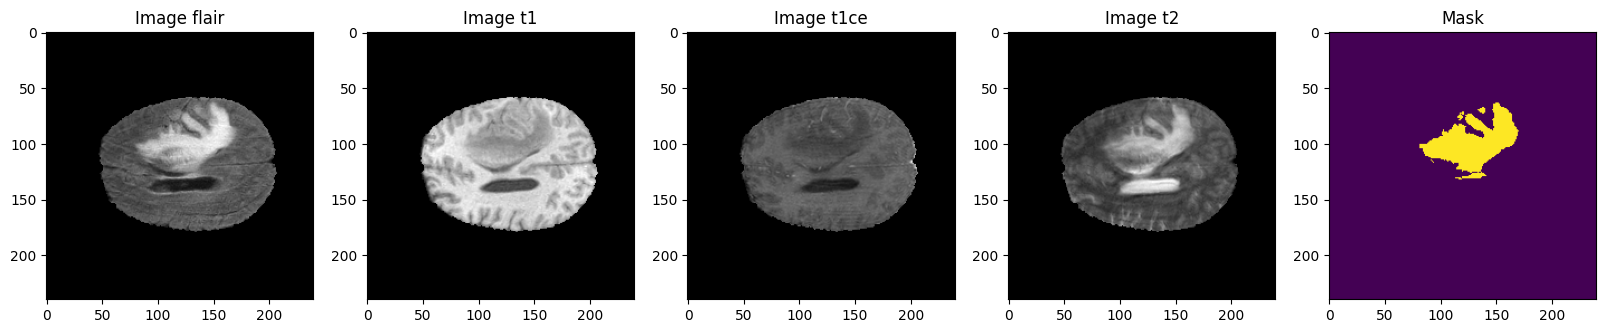

In [7]:
# Truy vấn dữ liệu của bệnh nhân BraTS20_Training_001 từ Cassandra
patient_id = 'BraTS20_Training_001'
row = session.execute("SELECT * FROM patient_data WHERE patient_id = %s", (patient_id,)).one()

# Lấy dữ liệu ảnh từ các đường dẫn lưu trong Cassandra
test_image_flair = nib.load(row.flair_path).get_fdata()  # Tải ảnh FLAIR
test_image_t1 = nib.load(row.t1_path).get_fdata()       # Tải ảnh T1
test_image_t1ce = nib.load(row.t1ce_path).get_fdata()   # Tải ảnh T1CE
test_image_t2 = nib.load(row.t2_path).get_fdata()       # Tải ảnh T2
test_mask = nib.load(row.seg_path).get_fdata()          # Tải nhãn phân đoạn (mask)

# Tạo biểu đồ để hiển thị các ảnh
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25  # Độ lệch lát cắt để chọn lát hiển thị

# Hiển thị ảnh FLAIR
ax1.imshow(test_image_flair[:, :, test_image_flair.shape[0]//2 - slice_w], cmap='gray')
ax1.set_title('Image flair')  # Tiêu đề: Ảnh FLAIR

# Hiển thị ảnh T1
ax2.imshow(test_image_t1[:, :, test_image_t1.shape[0]//2 - slice_w], cmap='gray')
ax2.set_title('Image t1')     # Tiêu đề: Ảnh T1

# Hiển thị ảnh T1CE
ax3.imshow(test_image_t1ce[:, :, test_image_t1ce.shape[0]//2 - slice_w], cmap='gray')
ax3.set_title('Image t1ce')   # Tiêu đề: Ảnh T1CE

# Hiển thị ảnh T2
ax4.imshow(test_image_t2[:, :, test_image_t2.shape[0]//2 - slice_w], cmap='gray')
ax4.set_title('Image t2')     # Tiêu đề: Ảnh T2

# Hiển thị nhãn (mask)
ax5.imshow(test_mask[:, :, test_mask.shape[0]//2 - slice_w])
ax5.set_title('Mask')         # Tiêu đề: Nhãn phân đoạn

plt.show()  # Hiển thị toàn bộ biểu đồ

### **Hiển thị toàn bộ dữ liệu Nifti -> In từng lát từ dữ liệu 3D**

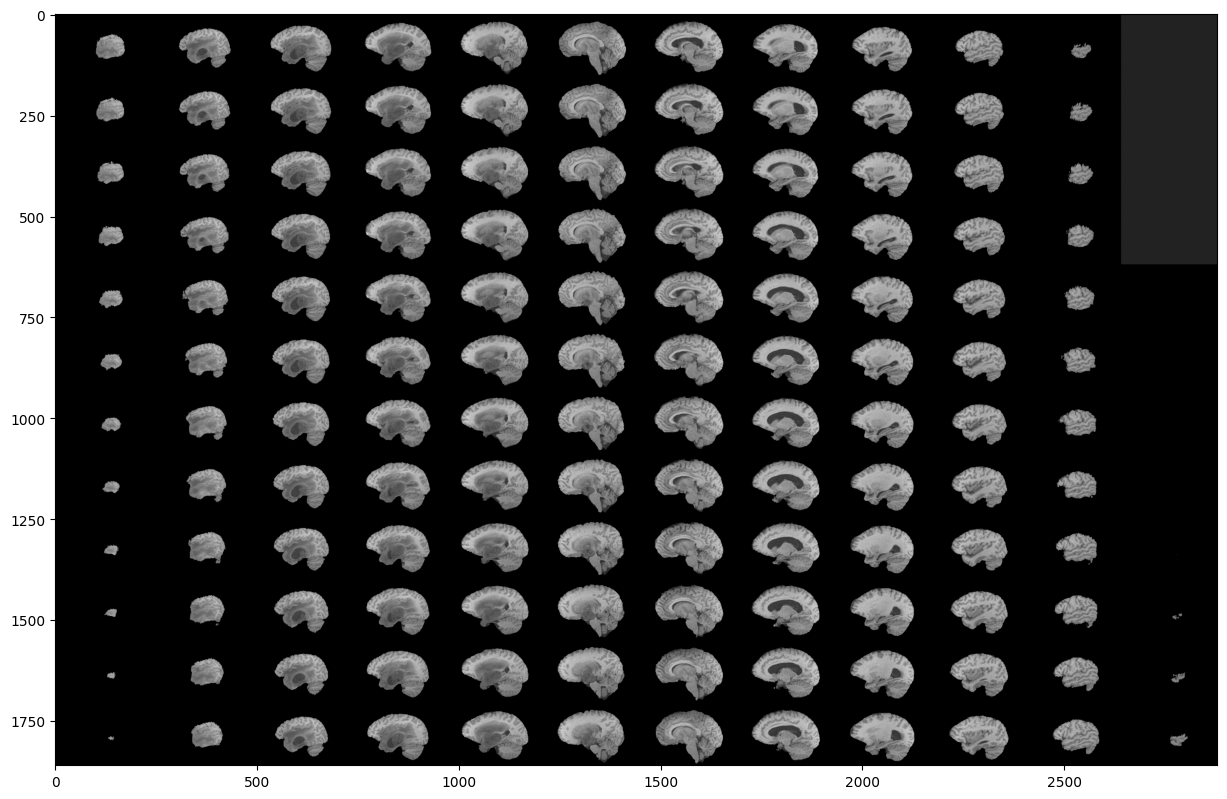

In [8]:
# Bỏ qua 50: -50 lát vì không có nhiều thứ để xem
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

### **Hiển thị phân đoạn khối u cho từng lát trên**

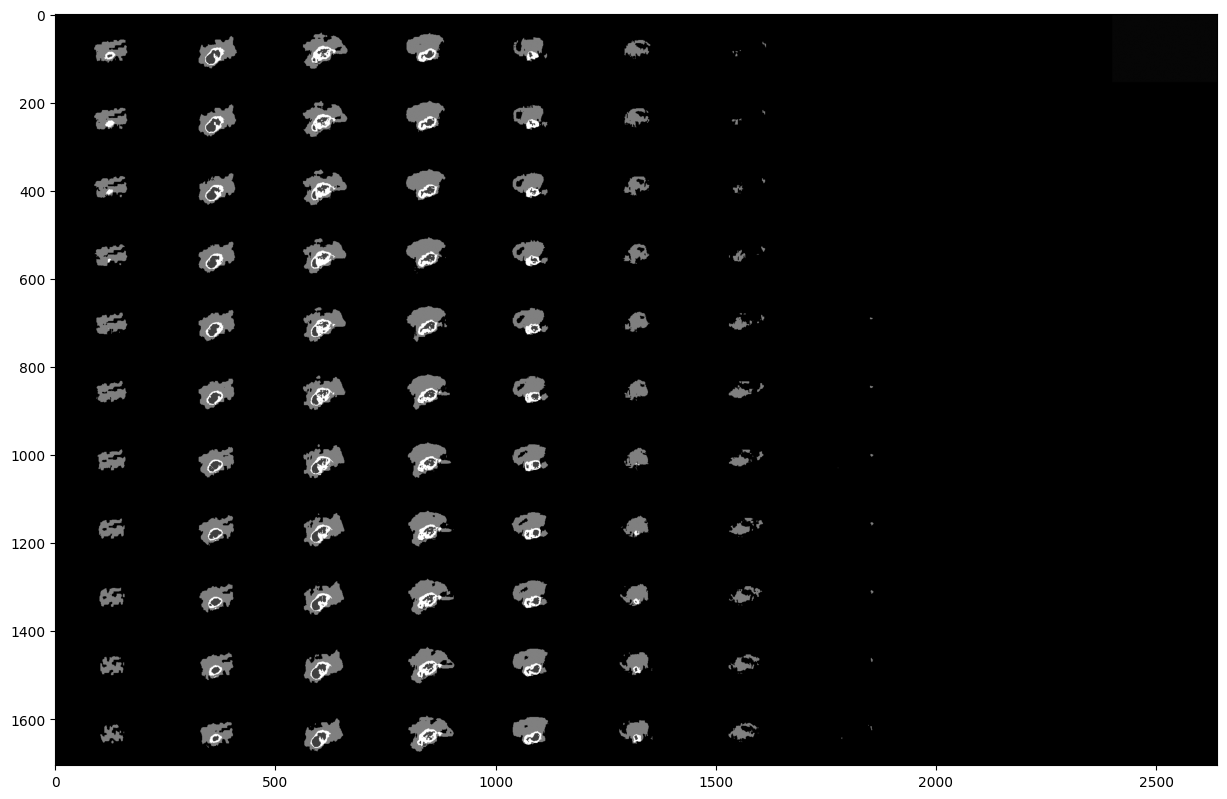

In [9]:
# Hiển thị phân đoạn khối u cho từng lát trên
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [10]:
# Sao chép tệp FLAIR từ đường dẫn trong Cassandra sang một tệp mới
shutil.copy2(row.flair_path, './test_gif_BraTS20_Training_001_flair.nii')

# Chuyển đổi tệp NIFTI vừa sao chép thành định dạng GIF
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

### **Hiển thị các phân đoạn khối u bằng cách sử dụng các hiệu ứng khác nhau**

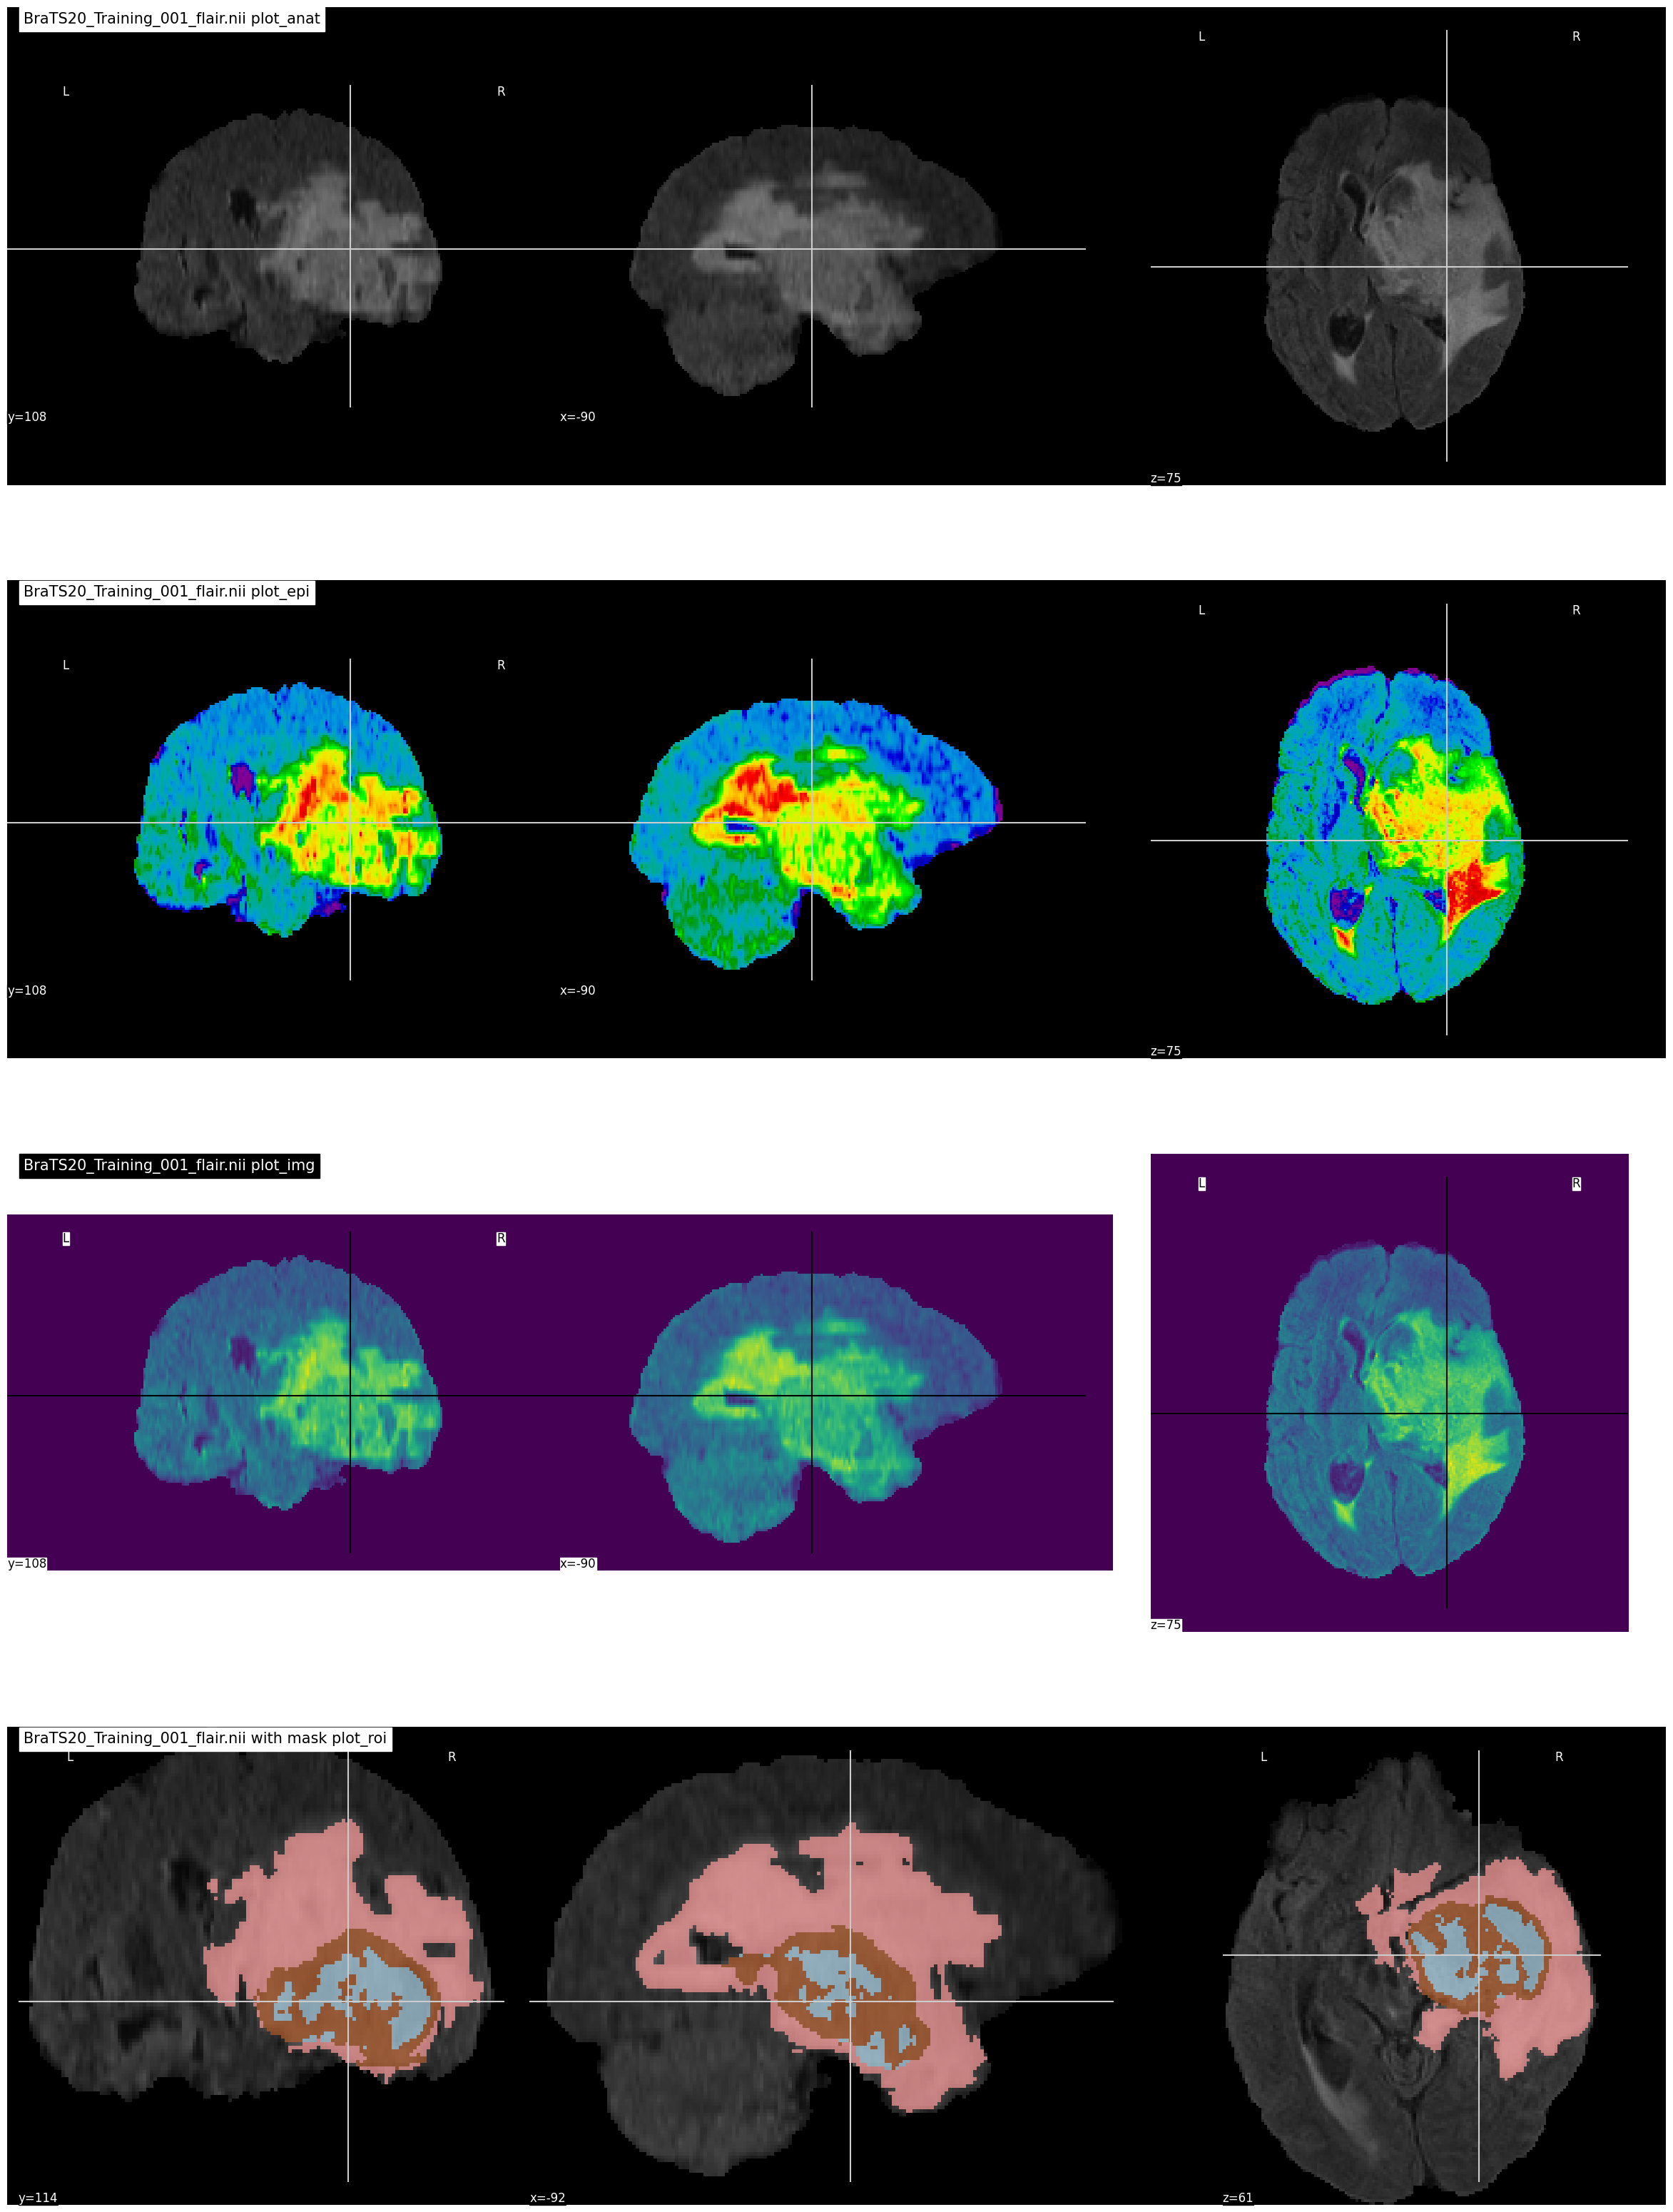

In [11]:
# Tải ảnh FLAIR và mask từ đường dẫn trong Cassandra
niimg = nl.image.load_img(row.flair_path)  # Tải ảnh FLAIR
nimask = nl.image.load_img(row.seg_path)   # Tải nhãn phân đoạn (mask)

# Tạo biểu đồ với 4 hàng
fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

# Vẽ ảnh giải phẫu (anatomical image) của FLAIR
nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

# Vẽ ảnh EPI (Echo Planar Imaging) của FLAIR
nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

# Vẽ ảnh thông thường (image) của FLAIR
nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

# Vẽ vùng quan tâm (ROI) với mask chồng lên ảnh FLAIR
nlplt.plot_roi(nimask,
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,  # Ảnh nền là FLAIR
               axes=axes[3], 
               cmap='Paired')  # Bảng màu cho mask

# Hiển thị biểu đồ
plt.show()

### **Mô hình unet**

In [12]:
# Nhập thư viện Keras backend để thực hiện các phép toán tensor
import tensorflow.keras.backend as K

# Hàm tính Dice Coefficient tổng quát cho 4 lớp
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4  # Số lớp phân đoạn: 0 (không phải u), 1 (hoại tử), 2 (phù nề), 3 (tăng cường)
    for i in range(class_num):  # Lặp qua từng lớp
        y_true_f = K.flatten(y_true[:,:,:,i])  # Làm phẳng nhãn thực tế của lớp i
        y_pred_f = K.flatten(y_pred[:,:,:,i])  # Làm phẳng nhãn dự đoán của lớp i
        intersection = K.sum(y_true_f * y_pred_f)  # Tính giao giữa nhãn thực và dự đoán
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))  # Công thức Dice
        if i == 0:  # Nếu là lớp đầu tiên
            total_loss = loss  # Gán loss của lớp 0 làm giá trị ban đầu
        else:  # Với các lớp còn lại
            total_loss = total_loss + loss  # Cộng dồn loss của các lớp
    total_loss = total_loss / class_num  # Tính trung bình loss của 4 lớp
    return total_loss  # Trả về Dice Coefficient trung bình

# Hàm tính Dice Coefficient cho lớp hoại tử (necrotic/core)
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))  # Giao giữa nhãn thực và dự đoán cho lớp 1
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)  # Công thức Dice

# Hàm tính Dice Coefficient cho lớp phù nề (edema)
def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))  # Giao giữa nhãn thực và dự đoán cho lớp 2
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)  # Công thức Dice

# Hàm tính Dice Coefficient cho lớp tăng cường (enhancing)
def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))  # Giao giữa nhãn thực và dự đoán cho lớp 3
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)  # Công thức Dice

# Hàm tính Precision (độ chính xác)
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # Tổng các điểm dương tính thực sự
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))  # Tổng các điểm được dự đoán là dương tính
    precision = true_positives / (predicted_positives + K.epsilon())  # Tính Precision
    return precision

# Hàm tính Sensitivity (độ nhạy, recall)
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # Tổng các điểm dương tính thực sự
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))  # Tổng các điểm thực sự là dương tính
    return true_positives / (possible_positives + K.epsilon())  # Tính Sensitivity

# Hàm tính Specificity (độ đặc hiệu)
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))  # Tổng các điểm âm tính thực sự
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))  # Tổng các điểm thực sự là âm tính
    return true_negatives / (possible_negatives + K.epsilon())  # Tính Specificity

In [13]:
# Định nghĩa kích thước ảnh đầu vào
IMG_SIZE = 128

# Hàm xây dựng mô hình U-Net
def build_unet(inputs, ker_init, dropout):
    # Encoder (phần thu nhỏ)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Trung tâm (bottleneck)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)  # Thêm dropout để giảm overfitting
    
    # Decoder (phần mở rộng)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(drop5))
    merge7 = concatenate([conv3, up7], axis=3)  # Kết nối skip connection
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
    
    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2,2))(conv9))
    merge = concatenate([conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    # Lớp đầu ra
    conv10 = Conv2D(4, (1,1), activation='softmax')(conv)  # 4 lớp phân đoạn
    
    return Model(inputs=inputs, outputs=conv10)  # Trả về mô hình

# Tạo lớp đầu vào với kích thước (128, 128, 2)
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Xây dựng và biên dịch mô hình
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), 
                       dice_coef, precision, sensitivity, specificity, 
                       dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

### **Tải dữ liệu từ cassandra**

In [ ]:
# Lấy danh sách tất cả các thư mục (ID bệnh nhân) từ Cassandra
rows = session.execute("SELECT patient_id FROM patient_data")
train_and_val_directories = [row.patient_id for row in rows]  # Lấy danh sách patient_id

# Hàm chuyển danh sách đường dẫn thành danh sách ID
def pathListIntoIds(dirList):
    x = []
    for i in range(0, len(dirList)):  # Lặp qua từng mục trong danh sách
        x.append(dirList[i][dirList[i].rfind('/')+1:])  # Lấy phần sau dấu '/' cuối cùng
    return x

# Chuyển danh sách thư mục thành danh sách ID
train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Chia dữ liệu thành tập train+test = 80% và tập validation = 20%
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)

# Chia tiếp tập train+test thành tập train = 85% và tập test = 15%
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

### **Lớp DataGenerator để tạo dữ liệu**

In [24]:
# Định nghĩa các hằng số từ trước
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22

# Lớp DataGenerator để tạo dữ liệu theo batch cho Keras
class DataGenerator(keras.utils.Sequence):
    'Tạo dữ liệu cho Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Khởi tạo'
        self.dim = dim  # Kích thước ảnh (128, 128)
        self.batch_size = batch_size  # Số mẫu trong mỗi batch
        self.list_IDs = list_IDs  # Danh sách ID của bệnh nhân
        self.n_channels = n_channels  # Số kênh đầu vào (2: FLAIR và T1CE)
        self.shuffle = shuffle  # Có xáo trộn dữ liệu hay không
        self.on_epoch_end()  # Cập nhật chỉ số khi khởi tạo

    def __len__(self):
        'Số batch trong mỗi epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))  # Tổng số batch

    def __getitem__(self, index):
        'Tạo một batch dữ liệu'
        # Tạo chỉ số cho batch hiện tại
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Lấy danh sách ID cho batch
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Tạo dữ liệu
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Cập nhật chỉ số sau mỗi epoch'
        self.indexes = np.arange(len(self.list_IDs))  # Tạo mảng chỉ số từ 0 đến số ID
        if self.shuffle == True:  # Nếu bật shuffle
            np.random.shuffle(self.indexes)  # Xáo trộn chỉ số

    def __data_generation(self, Batch_ids):
        'Tạo dữ liệu chứa batch_size mẫu'  # X: (n_samples, *dim, n_channels)
        # Khởi tạo mảng rỗng
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))  # Dữ liệu đầu vào
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))  # Nhãn gốc
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))  # Nhãn one-hot

        # Tạo dữ liệu
        for c, i in enumerate(Batch_ids):  # Lặp qua từng ID trong batch
            # Truy vấn dữ liệu từ Cassandra
            row = session.execute("SELECT * FROM patient_data WHERE patient_id = %s", (i,)).one()

            # Tải dữ liệu từ đường dẫn trong Cassandra
            flair = nib.load(row.flair_path).get_fdata()  # Ảnh FLAIR
            ce = nib.load(row.t1ce_path).get_fdata()      # Ảnh T1CE
            seg = nib.load(row.seg_path).get_fdata()      # Nhãn phân đoạn

            # Xử lý từng lát cắt (slice)
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))  # FLAIR
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))    # T1CE
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]  # Nhãn

        # Tạo mask
        y[y == 4] = 3  # Chuyển nhãn 4 thành 3 (theo chuẩn trước đó)
        mask = tf.one_hot(y, 4)  # Chuyển nhãn thành one-hot (4 lớp)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))  # Thay đổi kích thước mask về 128x128
        return X / np.max(X), Y  # Chuẩn hóa X và trả về cùng Y

# Tạo các generator cho train, validation, test
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

C:\Users\sutha\AppData\Local\Temp\ipykernel_18976\3619339251.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Dòng này có thể bỏ vì không có ý nghĩa trong biểu đồ cột đơn giản


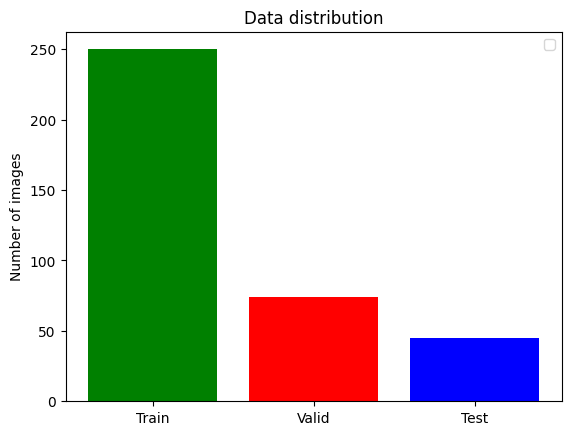

In [25]:
# Nhập thư viện cần thiết
import matplotlib.pyplot as plt

# Hàm hiển thị phân bố dữ liệu
def showDataLayout():
    # Vẽ biểu đồ cột
    plt.bar(["Train", "Valid", "Test"],  # Tên các tập: Train, Valid, Test
            [len(train_ids), len(val_ids), len(test_ids)],  # Số lượng ID trong từng tập
            align='center',  # Căn giữa các cột
            color=['green', 'red', 'blue'])  # Màu sắc cho từng cột
    
    # Thêm chú thích (legend), nhưng ở đây không cần vì không có nhiều đường
    plt.legend()  # Dòng này có thể bỏ vì không có ý nghĩa trong biểu đồ cột đơn giản

    # Đặt nhãn cho trục y
    plt.ylabel('Number of images')  # Số lượng ảnh

    # Đặt tiêu đề cho biểu đồ
    plt.title('Data distribution')  # Phân bố dữ liệu

    # Hiển thị biểu đồ
    plt.show()

# Gọi hàm để hiển thị
showDataLayout()

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5)
]

# **Train model**

In [ ]:
# Xóa session hiện tại để giải phóng bộ nhớ
K.clear_session()

# Huấn luyện mô hình
history = model.fit(training_generator,  # Generator cung cấp dữ liệu huấn luyện
                    epochs=15,           # Số epoch huấn luyện: 15 (giảm từ 35 để tiết kiệm thời gian)
                    steps_per_epoch=len(train_ids),  # Số bước mỗi epoch bằng số ID trong tập train
                    callbacks=callbacks,  # Danh sách callback (giả định đã định nghĩa trước)
                    validation_data=valid_generator)  # Dữ liệu xác nhận từ valid_generator

# Lưu mô hình sau khi huấn luyện
model.save("3D_MRI_Brain_tumor_segmentation.h5")  # Lưu dưới định dạng HDF5

### **Phiên dịch lại mô hình**

In [50]:
# In phiên bản TensorFlow để kiểm tra
print(f"Phiên bản TensorFlow: {tf.__version__}")

# Định nghĩa IMG_SIZE
IMG_SIZE = 128

# Định nghĩa lại các hàm tùy chỉnh
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Tải mô hình đã lưu với compile=False để tránh lỗi biên dịch
try:
    model = tf.keras.models.load_model(
        "3D_MRI_Brain_tumor_segmentation.h5",
        custom_objects={
            'dice_coef': dice_coef,
            'precision': precision,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'dice_coef_necrotic': dice_coef_necrotic,
            'dice_coef_edema': dice_coef_edema,
            'dice_coef_enhancing': dice_coef_enhancing
        },
        compile=False  # Tắt biên dịch tự động
    )
    print("Mô hình đã được tải thành công!")
    
    # Biên dịch lại mô hình thủ công nếu cần
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef,
                 precision, sensitivity, specificity,
                 dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]
    )
    print("Mô hình đã được biên dịch lại!")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")

# Hàm tiền xử lý ảnh
def preprocess_image(image_file, slice_index=None):
    img = nib.load(image_file).get_fdata()
    if slice_index is not None:
        img = img[:, :, slice_index]
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resized = img_resized / np.max(img_resized)
    return img_resized

# Hàm dự đoán
def predict(patient_id, slice_index):
    row = session.execute("SELECT flair_path, t1ce_path FROM patient_data WHERE patient_id = %s", (patient_id,)).one()
    image_paths = [row.flair_path, row.t1ce_path]
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, 2))
    X[0, :, :, 0] = preprocess_image(image_paths[0], slice_index)
    X[0, :, :, 1] = preprocess_image(image_paths[1], slice_index)
    pred = model.predict(X)
    return np.argmax(pred[0], axis=-1)

# Ví dụ sử dụng
patient_id = 'BraTS20_Training_001'
slice_index = 75
prediction = predict(patient_id, slice_index)
print("Dự đoán đã hoàn tất!")

Phiên bản TensorFlow: 2.19.0
Mô hình đã được tải thành công!
Mô hình đã được biên dịch lại!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Dự đoán đã hoàn tất!


In [51]:
# Hàm lấy nhãn phân đoạn từ dự đoán
def get_classification(pred):
    # Lấy lớp có xác suất cao nhất cho mỗi pixel
    class_predictions = np.argmax(pred, axis=-1)  # Tính argmax theo trục cuối cùng (trục lớp)
    return class_predictions  # Trả về mảng nhãn phân đoạn

In [52]:
get_classification(prediction)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       56, 53, 51, 50, 86, 70, 64, 61, 61, 60, 53, 51, 52, 53, 59, 59, 60,
       62, 63, 64, 65, 67, 69, 41, 42, 42, 43, 51, 51, 52, 53, 54, 53, 53,
       54, 56, 58,  0,  0,  0,  0, 95, 95,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

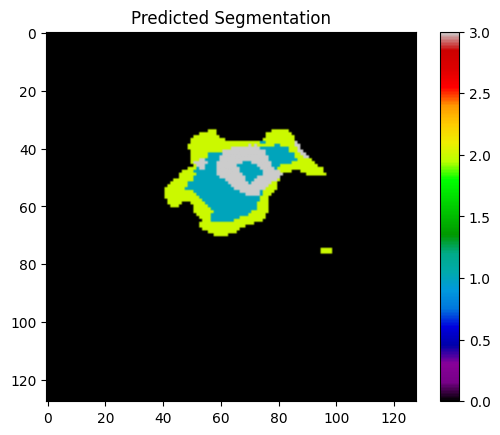

In [54]:
# Hàm trực quan hóa dự đoán
def visualize_prediction(prediction):
    plt.imshow(prediction, cmap='nipy_spectral')  # Hiển thị ảnh với bảng màu 'nipy_spectral'
    plt.title('Predicted Segmentation')  # Đặt tiêu đề
    plt.colorbar()  # Thêm thanh màu
    plt.show()  # Hiển thị biểu đồ

# Trực quan hóa nhãn phân đoạn
visualize_prediction(prediction)

Mô hình đã được tải thành công!
Đã tải lịch sử huấn luyện từ 'training_per_class.log'


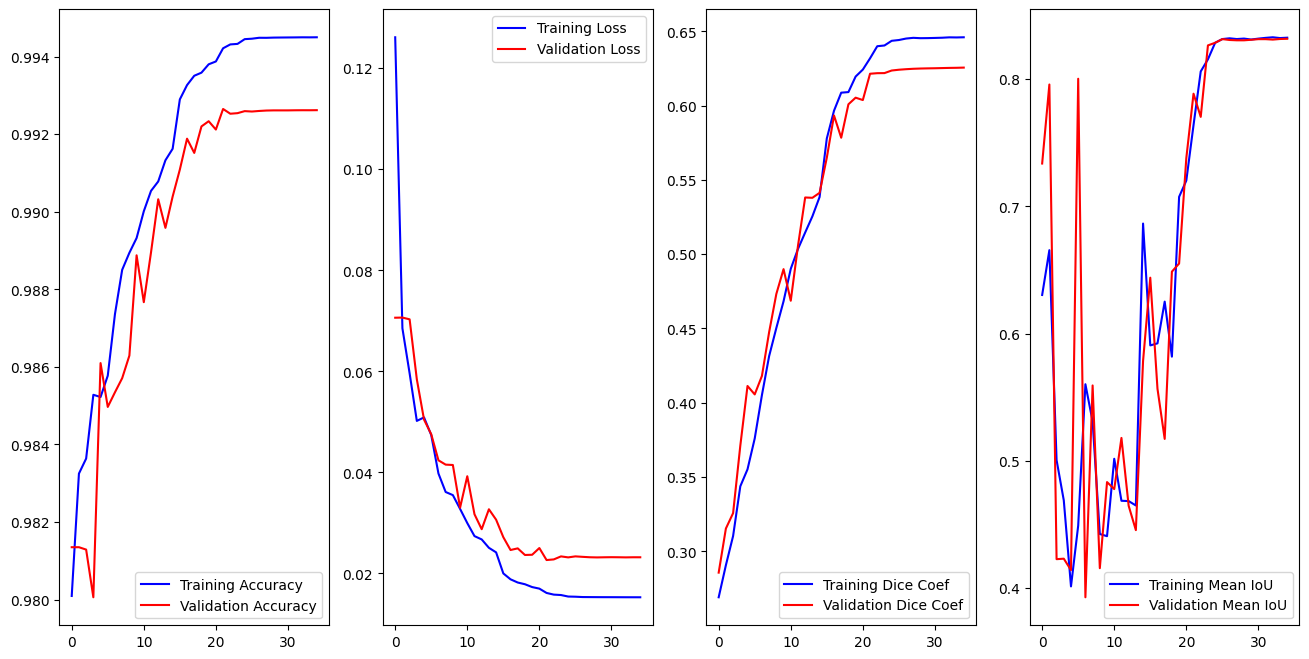

In [59]:
# Tải mô hình đã lưu
model = tf.keras.models.load_model(
    "3D_MRI_Brain_tumor_segmentation.h5",
    custom_objects={
        'MeanIoU': tf.keras.metrics.MeanIoU(num_classes=4),
        "dice_coef": dice_coef,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "dice_coef_necrotic": dice_coef_necrotic,
        "dice_coef_edema": dice_coef_edema,
        "dice_coef_enhancing": dice_coef_enhancing
    },
    compile=False
)
print("Mô hình đã được tải thành công!")

# Thử tải lịch sử huấn luyện từ file CSV
try:
    history = pd.read_csv('training_per_class.log', sep=',', engine='python')
    hist = history
    print("Đã tải lịch sử huấn luyện từ 'training_per_class.log'")
except FileNotFoundError:
    print("Không tìm thấy 'training_per_class.log'. Bỏ qua phần vẽ biểu đồ lịch sử huấn luyện.")
    hist = None

# Nếu có lịch sử, vẽ biểu đồ
if hist is not None:
    # Trích xuất các chỉ số từ history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    epoch = range(len(acc))
    loss = hist['loss']
    val_loss = hist['val_loss']
    train_dice = hist['dice_coef']
    val_dice = hist['val_dice_coef']

    # Vẽ biểu đồ
    f, ax = plt.subplots(1, 4, figsize=(16, 8))

    ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
    ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
    ax[0].legend()

    ax[1].plot(epoch, loss, 'b', label='Training Loss')
    ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
    ax[1].legend()

    ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coef')
    ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coef')
    ax[2].legend()

    ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training Mean IoU')
    ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation Mean IoU')
    ax[3].legend()

    plt.show()
else:
    print("Không vẽ biểu đồ vì thiếu dữ liệu lịch sử.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


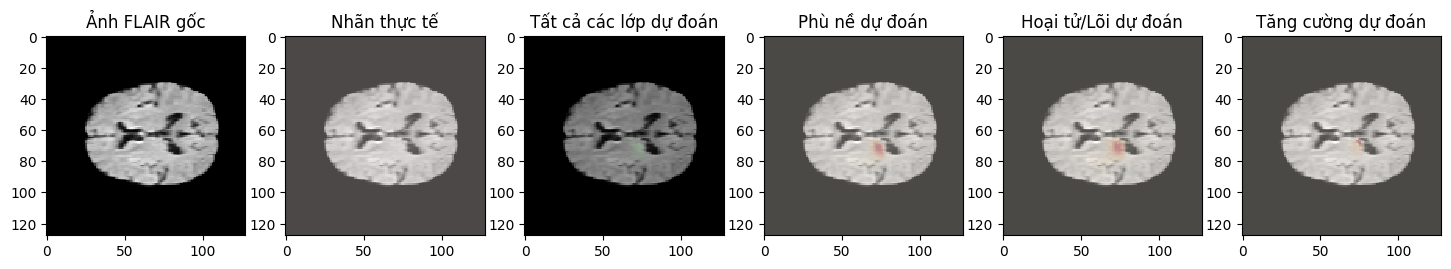

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step


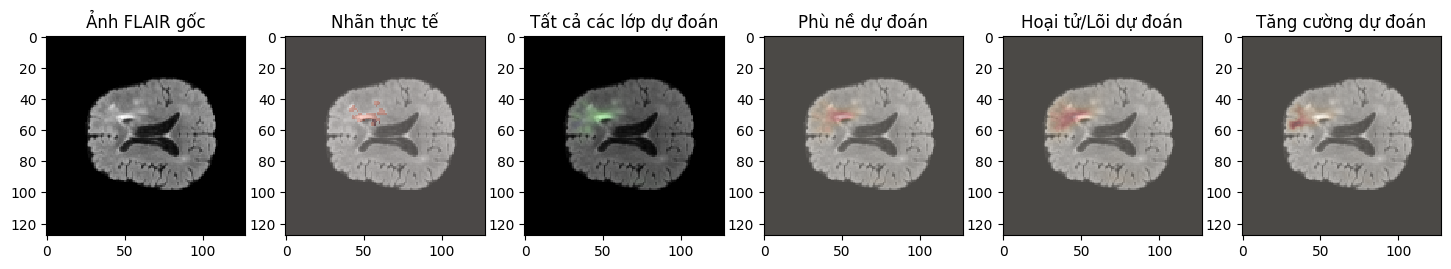

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step


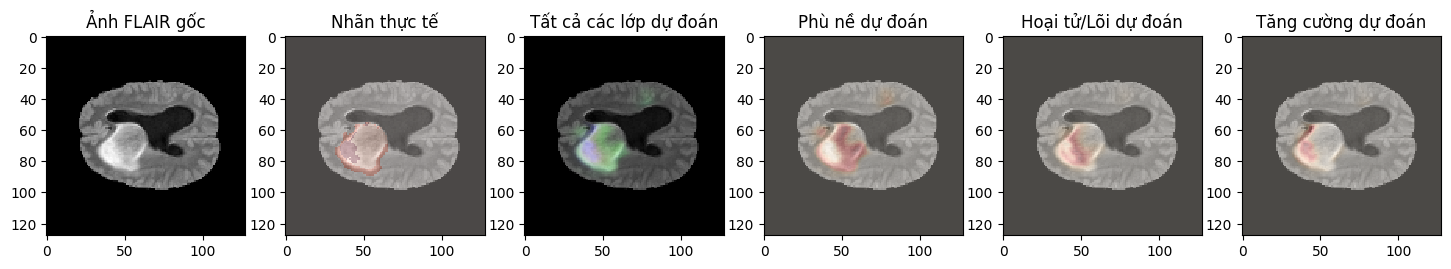

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


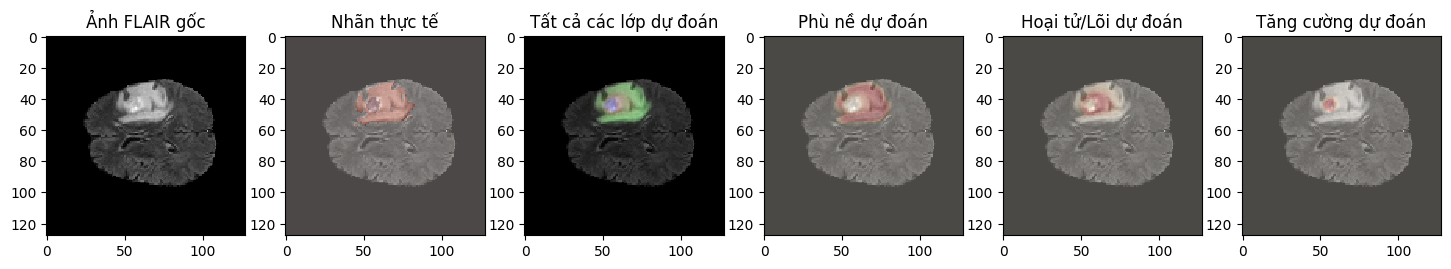

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step


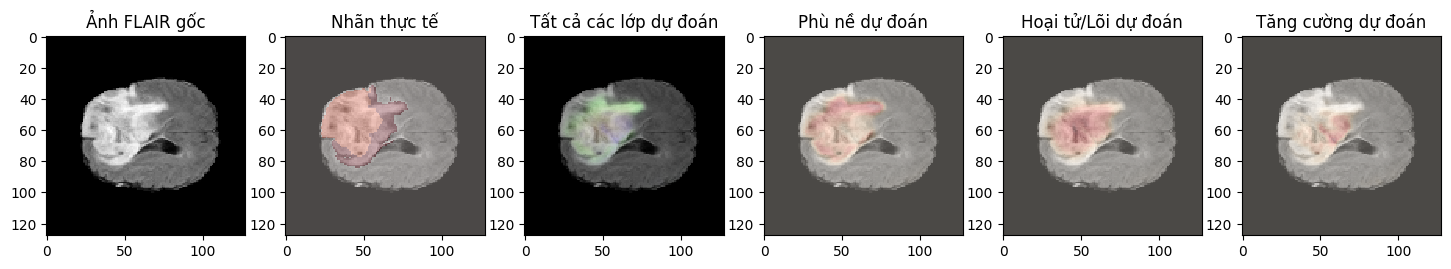

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step


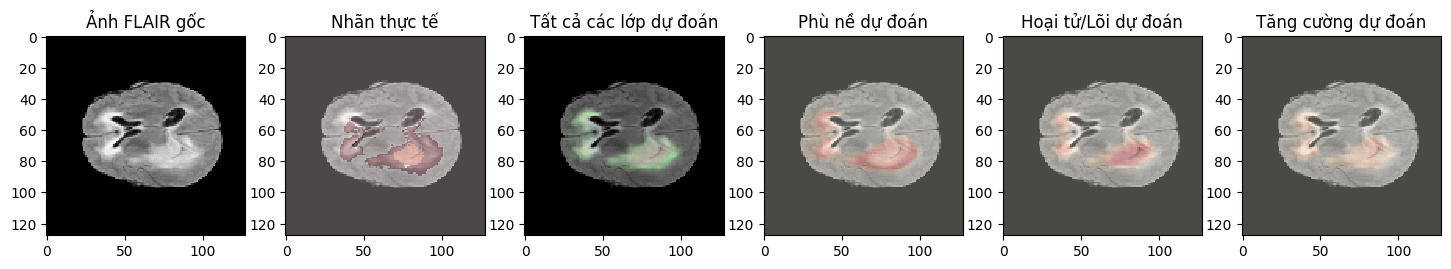

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step


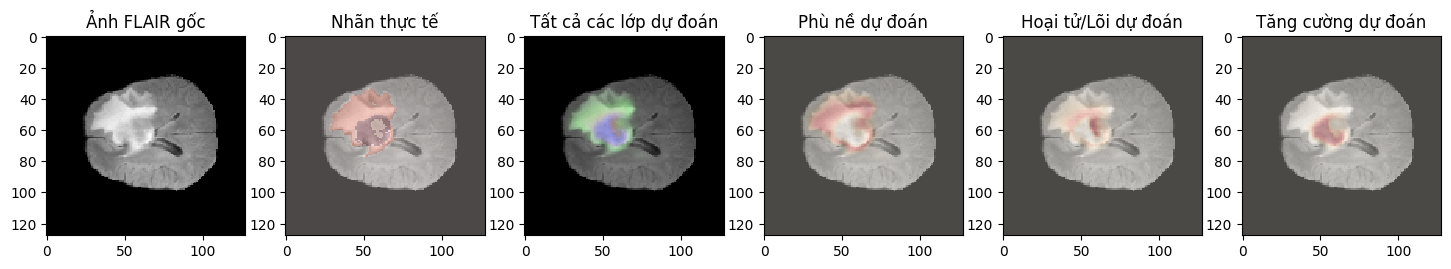

In [ ]:
# Định nghĩa các lớp phân đoạn bằng tiếng Việt
SEGMENT_CLASSES = {
    0: 'Không phải khối u',
    1: 'Hoại tử/Lõi',
    2: 'Phù nề',
    3: 'Tăng cường'
}

# Hàm dự đoán từ đường dẫn
def predictByPath(patient_id):
    # Truy vấn dữ liệu từ Cassandra
    row = session.execute("SELECT flair_path, t1ce_path FROM patient_data WHERE patient_id = %s", (patient_id,)).one()
    
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))  # Mảng đầu vào cho dự đoán
    
    # Tải dữ liệu FLAIR
    flair = nib.load(row.flair_path).get_fdata()
    
    # Tải dữ liệu T1CE
    ce = nib.load(row.t1ce_path).get_fdata()
    
    # Tiền xử lý từng lát cắt
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))  # FLAIR
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))    # T1CE
    
    # Dự đoán và chuẩn hóa đầu vào
    return model.predict(X / np.max(X), verbose=1)

# Hàm hiển thị dự đoán theo ID
def showPredictsById(case, start_slice=60):
    # Truy vấn dữ liệu từ Cassandra
    row = session.execute("SELECT flair_path, seg_path FROM patient_data WHERE patient_id = %s", (case,)).one()
    
    # Tải ảnh gốc (FLAIR) và nhãn thực tế (ground truth)
    gt = nib.load(row.seg_path).get_fdata()  # Nhãn thực tế
    origImage = nib.load(row.flair_path).get_fdata()  # Ảnh FLAIR gốc
    
    # Dự đoán
    p = predictByPath(case)
    
    # Tách các lớp từ kết quả dự đoán
    core = p[:, :, :, 1]  # Lớp hoại tử/lõi
    edema = p[:, :, :, 2]  # Lớp phù nề
    enhancing = p[:, :, :, 3]  # Lớp tăng cường
    
    # Tạo biểu đồ
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))
    
    # Hiển thị ảnh gốc làm nền cho tất cả các ô
    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), 
                        cmap="gray", interpolation='none')
    
    # Ô 1: Ảnh gốc
        axarr[0].title.set_text('Ảnh FLAIR gốc')
        
        # Ô 2: Nhãn thực tế
        curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Nhãn thực tế')
    
    # Ô 3: Tất cả các lớp dự đoán
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('Tất cả các lớp dự đoán')
    
    # Ô 4: Lớp phù nề dự đoán
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[2]} dự đoán')
    
    # Ô 5: Lớp hoại tử/lõi dự đoán
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[1]} dự đoán')
    
    # Ô 6: Lớp tăng cường dự đoán
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} dự đoán')
    
    plt.show()

# Hiển thị dự đoán cho các ID trong tập test
for i in range(min(7, len(test_ids))):  # Hiển thị tối đa 7 mẫu hoặc số lượng test_ids
    showPredictsById(case=test_ids[i])

In [84]:
import random
# Hàm dự đoán phân đoạn từ patient_id
def predict_segmentation(patient_id):
    row = session.execute("SELECT flair_path, t1ce_path FROM patient_data WHERE patient_id = %s", (patient_id,)).one()
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    flair = nib.load(row.flair_path).get_fdata()
    ce = nib.load(row.t1ce_path).get_fdata()
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    return model.predict(X / np.max(X), verbose=1)

# Hàm hiển thị phân đoạn dự đoán
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Chọn một bệnh nhân ngẫu nhiên
    random_sample = random.choice(samples_list)

    # Dự đoán phân đoạn của bệnh nhân
    predicted_seg = predict_segmentation(random_sample)

    # Tải phân đoạn gốc (nhãn thực tế) của bệnh nhân từ Cassandra
    row = session.execute("SELECT seg_path FROM patient_data WHERE patient_id = %s", (random_sample,)).one()
    seg = nib.load(row.seg_path).get_fdata()

    # Thay đổi kích thước nhãn thực tế để khớp với dự đoán
    seg = cv2.resize(seg[:, :, slice_to_plot + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Tách các lớp từ phân đoạn dự đoán
    all_classes = predicted_seg[slice_to_plot, :, :, 1:4]  # Lớp 1, 2, 3 (bỏ lớp 0)
    not_tumor = predicted_seg[slice_to_plot, :, :, 0]      # Lớp 0: Không phải khối u
    core = predicted_seg[slice_to_plot, :, :, 1]           # Lớp 1: Hoại tử/Lõi
    edema = predicted_seg[slice_to_plot, :, :, 2]          # Lớp 2: Phù nề
    enhancing = predicted_seg[slice_to_plot, :, :, 3]      # Lớp 3: Tăng cường

    # In số bệnh nhân
    print("Số bệnh nhân: ", random_sample)

    # Tạo biểu đồ với 6 ô
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Ô 1: Phân đoạn gốc
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Phân đoạn gốc')

    # Ô 2: Tất cả các lớp dự đoán
    axstest[1].imshow(all_classes, cmap, norm)
    axstest[1].set_title('Phân đoạn dự đoán - Tất cả các lớp')

    # Ô 3: Lớp không phải khối u
    axstest[2].imshow(not_tumor)
    axstest[2].set_title('Phân đoạn dự đoán - Không phải khối u')

    # Ô 4: Lớp hoại tử/lõi
    axstest[3].imshow(core)
    axstest[3].set_title('Phân đoạn dự đoán - Hoại tử/Lõi')

    # Ô 5: Lớp phù nề
    axstest[4].imshow(edema)
    axstest[4].set_title('Phân đoạn dự đoán - Phù nề')

    # Ô 6: Lớp tăng cường
    axstest[5].imshow(enhancing)
    axstest[5].set_title('Phân đoạn dự đoán - Tăng cường')

    # Thêm khoảng cách giữa các ô
    plt.subplots_adjust(wspace=0.8)

    # Hiển thị biểu đồ
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step
Số bệnh nhân:  BraTS20_Training_305


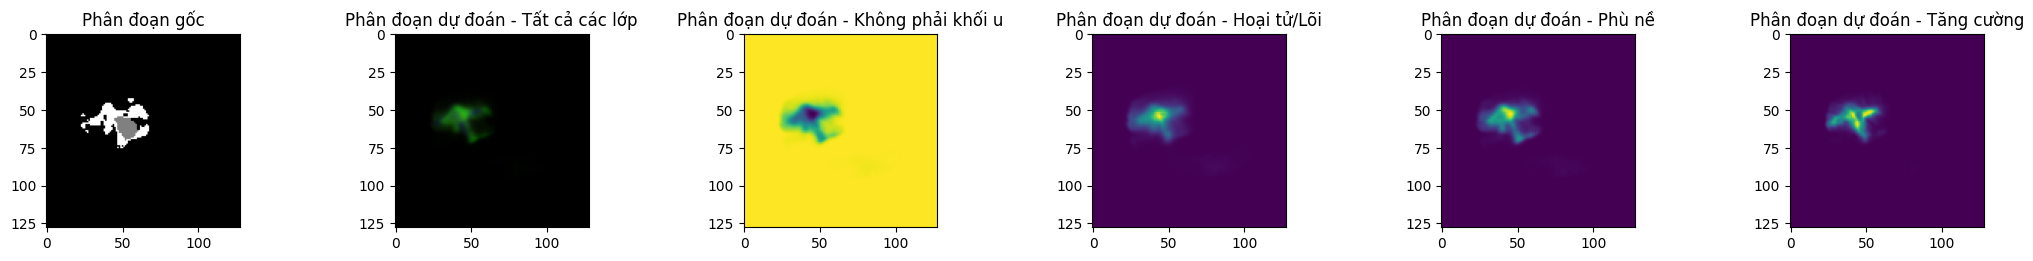

In [85]:
show_predicted_segmentations(test_ids, slice_to_plot=60, cmap='gray', norm=None)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step
Số bệnh nhân:  BraTS20_Training_269


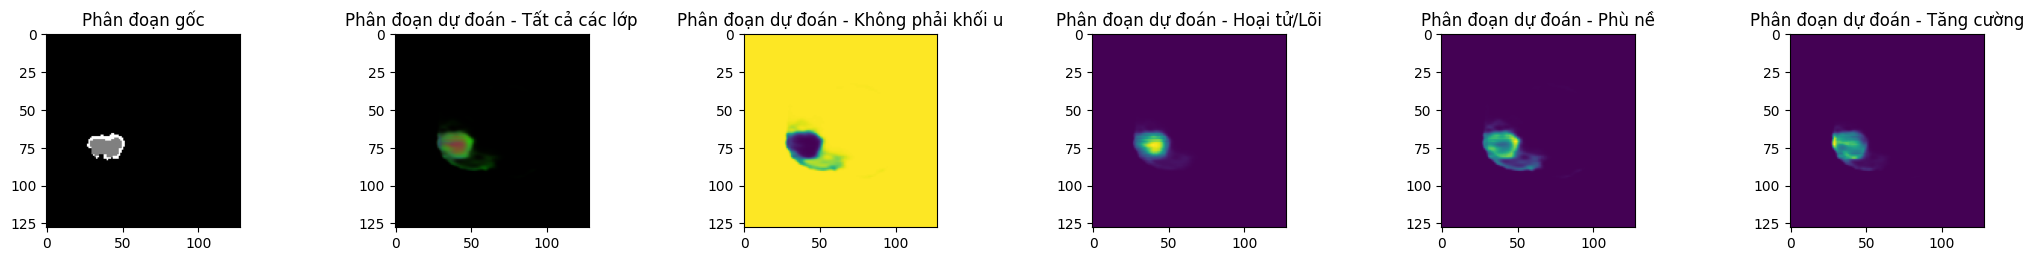

In [86]:
show_predicted_segmentations(test_ids, slice_to_plot=60, cmap='gray', norm=None)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step
Số bệnh nhân:  BraTS20_Training_297


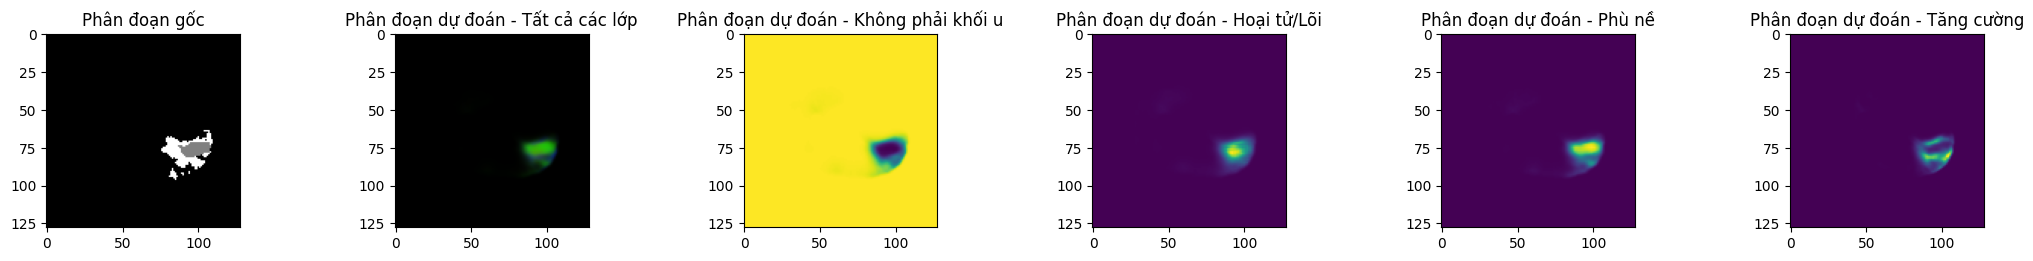

In [87]:
show_predicted_segmentations(test_ids, slice_to_plot=60, cmap='gray', norm=None)

In [75]:
# Biên dịch mô hình
model.compile(
    loss="categorical_crossentropy",  # Hàm mất mát: categorical crossentropy
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer Adam với learning rate 0.001
    metrics=[
        'accuracy',  # Độ chính xác
        tf.keras.metrics.MeanIoU(num_classes=4),  # Mean IoU cho 4 lớp
        dice_coef,  # Dice coefficient tổng quát
        precision,  # Độ chính xác (precision)
        sensitivity,  # Độ nhạy (recall)
        specificity,  # Độ đặc hiệu
        dice_coef_necrotic,  # Dice cho lớp hoại tử
        dice_coef_edema,  # Dice cho lớp phù nề
        dice_coef_enhancing  # Dice cho lớp tăng cường
    ]
)

# Đánh giá mô hình trên dữ liệu kiểm tra
print("Evaluate on test data")
results = model.evaluate(
    test_generator,  # Generator cung cấp dữ liệu kiểm tra từ Cassandra
    batch_size=100,  # Kích thước batch: 100
    callbacks=callbacks  # Danh sách callback (giả định đã định nghĩa trước)
)
print("test loss, test acc:", results)  # In kết quả: loss và accuracy (cùng các metrics khác)

Evaluate on test data
45/45 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.9897 - dice_coef: 0.4497 - dice_coef_edema: 0.5224 - dice_coef_enhancing: 0.4289 - dice_coef_necrotic: 0.3577 - loss: 0.0287 - mean_io_u_5: 0.7758 - precision: 0.9928 - sensitivity: 0.9861 - specificity: 0.9976
test loss, test acc: [0.03072378970682621, 0.9887583255767822, 0.7765990495681763, 0.4665882885456085, 0.9921796917915344, 0.9851605892181396, 0.9973236918449402, 0.38925987482070923, 0.5541242957115173, 0.43301844596862793]


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step


<Figure size 640x480 with 0 Axes>

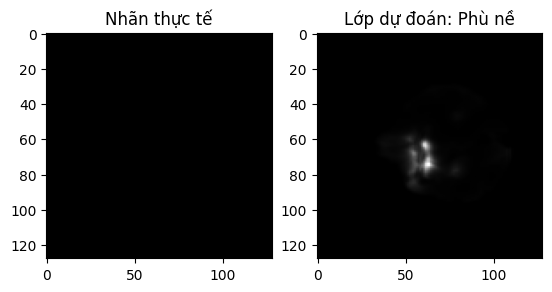

In [88]:
# Hàm dự đoán dựa trên patient_id từ Cassandra
def predictByPath(patient_id):
    row = session.execute("SELECT flair_path, t1ce_path FROM patient_data WHERE patient_id = %s", (patient_id,)).one()
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    flair = nib.load(row.flair_path).get_fdata()
    ce = nib.load(row.t1ce_path).get_fdata()
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    return model.predict(X / np.max(X), verbose=1)

# Lấy case từ test_ids và dự đoán
case = test_ids[3]  # Lấy toàn bộ ID từ test_ids[3] thay vì chỉ lấy 3 ký tự cuối
gt_row = session.execute("SELECT seg_path FROM patient_data WHERE patient_id = %s", (case,)).one()
gt = nib.load(gt_row.seg_path).get_fdata()  # Tải nhãn thực tế từ Cassandra
p = predictByPath(case)  # Dự đoán cho case

# Tách các lớp từ dự đoán
core = p[:, :, :, 1]      # Lớp hoại tử/lõi
edema = p[:, :, :, 2]     # Lớp phù nề
enhancing = p[:, :, :, 3] # Lớp tăng cường

# Thiết lập lát cắt và lớp cần đánh giá
i = 40          # Lát cắt tại vị trí 40
eval_class = 2  # Lớp cần đánh giá: 2 (Phù nề)

# Chỉ giữ lớp cần đánh giá trong nhãn thực tế
gt[gt != eval_class] = 0  # Đặt các giá trị không phải lớp Phù nề thành 0 (sửa từ 1 thành 0 để nhất quán)

# Thay đổi kích thước nhãn thực tế
resized_gt = cv2.resize(gt[:, :, i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))  # Resize về 128x128

# Vẽ biểu đồ so sánh
plt.figure()  # Tạo figure mới
f, axarr = plt.subplots(1, 2)  # Tạo 2 subplot cạnh nhau

axarr[0].imshow(resized_gt, cmap="gray")  # Hiển thị nhãn thực tế
axarr[0].title.set_text('Nhãn thực tế')   # Tiêu đề: Nhãn thực tế

axarr[1].imshow(p[i, :, :, eval_class], cmap="gray")  # Hiển thị dự đoán lớp Phù nề
axarr[1].title.set_text(f'Lớp dự đoán: {SEGMENT_CLASSES[eval_class]}')  # Tiêu đề: Lớp dự đoán - Phù nề

plt.show()  # Hiển thị biểu đồ

In [ ]:
# Đánh giá mô hình trên dữ liệu kiểm tra
results = model.evaluate(
    test_generator,  # Generator cung cấp dữ liệu kiểm tra từ Cassandra
    batch_size=100,  # Kích thước batch: 100 mẫu mỗi lần đánh giá
    callbacks=callbacks  # Danh sách callback (giả định đã định nghĩa trước)
)

# Danh sách mô tả các chỉ số bằng tiếng Việt
descriptions = [
    "Mất mát",              # Loss
    "Độ chính xác",         # Accuracy
    "IoU trung bình",       # MeanIoU
    "Hệ số Dice",           # Dice coefficient
    "Độ chính xác (Precision)",  # Precision
    "Độ nhạy",              # Sensitivity
    "Độ đặc hiệu",          # Specificity
    "Hệ số Dice Hoại tử",   # Dice coef Necrotic
    "Hệ số Dice Phù nề",    # Dice coef Edema
    "Hệ số Dice Tăng cường" # Dice coef Enhancing
]

# Kết hợp danh sách kết quả và mô tả
results_list = zip(results, descriptions)

# Hiển thị từng chỉ số kèm mô tả
print("\nĐánh giá mô hình trên tập kiểm tra:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")  # In chỉ số với 4 chữ số thập phân

43/45 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.9859 - dice_coef: 0.4728 - dice_coef_edema: 0.5376 - dice_coef_enhancing: 0.4042 - dice_coef_necrotic: 0.4326 - loss: 0.0373 - mean_io_u_5: 0.7752 - precision: 0.9907 - sensitivity: 0.9810 - specificity: 0.9968 